In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams['font.size'] = 20

# Engineeering features


En este notebook vamos a ver principalmente:

1) Tratamiento de NAs values

2) Tratamiento de variables categóricas

3) Selección de variables

Vamos a trabajar con el asiguiente dataset llamado __House Prices__ que puedes encontrar
[aquí](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

###  Bajamos el dataset y hacemos un simple modelo  (Regresión multilineal)


In [3]:
path = "./data/house-prices-advanced-regression-techniques/train.csv"
houses = pd.read_csv(path)

In [4]:
houses_num =  houses.select_dtypes(include=[np.number])

In [5]:
houses_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


#### Problema:  ¿Podemos predecir el precio de venta?

Hagamos una regresión multilineal con todas las variables numéricas

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

target_col = "SalePrice"
Xy = houses_num
X = Xy.drop(target_col, axis=1)
y = Xy[target_col]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_dev_hat = reg.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

> ¿Qué ha pasado?


Tenemos valores nulos.

# 1. Tratamiento de Nas

In [9]:
houses_num =  houses.select_dtypes(include=[np.number])
houses_num.shape

(1460, 38)

In [10]:
var = houses_num.isnull().sum()
var[var>0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

###### Método 1: eliminar las columnas con NAs

In [11]:
columnswithNulls = ['LotFrontage','GarageYrBlt',"MasVnrArea"]

In [12]:
houses_num.drop(columnswithNulls,axis=1).isnull().sum().sum()

0

In [13]:
target_col = "SalePrice"
Xy = houses_num.drop(columnswithNulls,axis=1)
X = Xy.drop(target_col, axis=1)
y = Xy[target_col]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_dev_hat = reg.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

34461.69716294498


###### Método 2: eliminar las filas con NAs

In [14]:
Xy = houses_num
print(Xy.shape)
Xy = Xy.dropna()
print(Xy.shape)

(1460, 38)
(1121, 38)


In [15]:
X = Xy.drop(target_col, axis=1).dropna()
y = Xy[target_col]
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_dev_hat = reg.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

46685.432355986566


###### Método 3: sustituir NAs por valores adecuados

La idea es sustituir por valores que entran dentro del dominio de 
la variable; por ejemplo 0, un valor aleatorio, una media, una mediana, moda o incluso un valor estimado por otro modelo predictivo.

In [16]:
columnswithNulls = ['LotFrontage','GarageYrBlt',"MasVnrArea"]

In [17]:
houses[columnswithNulls].describe()

,LotFrontage,GarageYrBlt,MasVnrArea
count,1201.000000,1379.000000,1452.000000
mean,70.049958,1978.506164,103.685262
std,24.284752,24.689725,181.066207
min,21.000000,1900.000000,0.000000
25%,59.000000,1961.000000,0.000000
50%,69.000000,1980.000000,0.000000
75%,80.000000,2002.000000,166.000000
max,313.000000,2010.000000,1600.000000


##### Por un valor aleatorio

In [18]:
import random
aux = houses_num.copy()
aux[columnswithNulls].isnull().sum().sum()

348

In [19]:
for col in columnswithNulls:
    minVal =  aux[col].min()
    maxVal = aux[col].max()
    aux.loc[aux[col].isnull(),col] =  random.randrange(minVal,maxVal)

In [20]:
X = aux.drop(target_col, axis=1).dropna()
y = aux[target_col]
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_dev_hat = reg.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

34376.17631596523


##### Por la media

In [21]:
aux = houses_num.copy()
aux[columnswithNulls].isnull().sum().sum()

348

In [22]:
for col in columnswithNulls:
    meanVal =  aux[col].mean()
    aux.loc[aux[col].isnull(),col] =  meanVal

In [23]:
X = aux.drop(target_col, axis=1).dropna()
y = aux[target_col]
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_dev_hat = reg.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

34086.18004235941


##### Por el mínimo

In [24]:
columnswithNulls

['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

In [25]:
aux = houses_num.copy()
for col in columnswithNulls:
    minVal =  aux[col].min()
    aux.loc[aux[col].isnull(),col] =  minVal

In [26]:
X = aux.drop(target_col, axis=1).dropna()
y = aux[target_col]
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_dev_hat = reg.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

33728.24586659505


##### Por el mínimo y creación de columnas binarias indicando posición de valores nulos

In [27]:
aux = houses_num.copy()
for col in columnswithNulls:
    aux[col+'bin'] = 1
    aux.loc[aux[col].isnull(),col+'bin'] = 0
    minVal =  aux[col].min()
    aux.loc[aux[col].isnull(),col] =  minVal

In [28]:
X = aux.drop(target_col, axis=1).dropna()
y = aux[target_col]
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_dev_hat = reg.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

33740.8550609176


# 2. Variables categóricas: tratamiento

En numerosas ocasiones nos enfrentaremos a variables categóricas las cuales tienen una fuerte correlación con la variable a predecir. Por ejemplo en el caso del predcio de venta de casas, claramente el tipo de barrio es un variable totalmente importante para predecir su precio. Un casa de msimas carazterísticas no tiene el mismo valor en Extremadura que en Barcelona. Veremos aquí qué metodologías existen para tratar variables categóricas:

1) Labelizar

2) One-hot-encoding

3) Value encoding

Busquemos en nuestro dataset quienes son las variables categóricas

In [29]:
houses_cat =  houses.select_dtypes(include=[np.object])

In [30]:
houses_cat.shape

(1460, 43)

In [31]:
houses_cat.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


Vamos a predecir el valor de las casa con una única variable categórica:

"Neighborhood"

## 2.1) Labelización

In [32]:
houses = pd.read_csv(path, index_col="Id")
houses['Neighborhood'].unique(),houses['Neighborhood'].nunique()

(array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
        'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
        'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
        'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
        'Blueste'], dtype=object), 25)

In [33]:

target_col = "SalePrice"
categorical_column = "Neighborhood"
Xy = houses[[categorical_column, target_col]]
X = Xy.drop(target_col, axis=1)
y = Xy[target_col]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

In [34]:
classes = X[categorical_column].unique()
col2num = {classes[i]: i for i in range(len(classes))}
X_train[categorical_column + "_label"] = X_train[categorical_column].apply(lambda cls: col2num[cls])
X_dev[categorical_column + "_label"] = X_dev[categorical_column].apply(lambda cls: col2num[cls])

In [35]:
reg = LinearRegression()
reg.fit(X_train[[categorical_column + "_label"]], y_train)
y_dev_hat = reg.predict(X_dev[[categorical_column + "_label"]])
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

79925.19665925231


Text(0, 0.5, 'Sale Price')

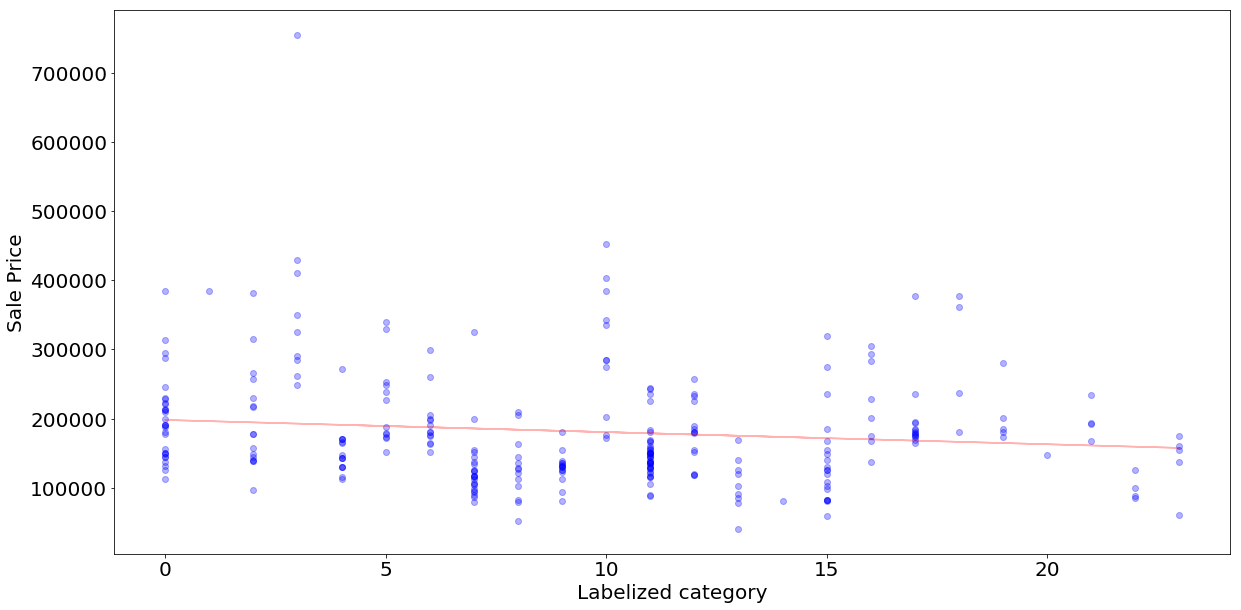

In [36]:
# Ploting real data y (blue)
plt.scatter(X_dev[[categorical_column + "_label"]], y_dev, alpha=0.3, c="blue")
# versus predicted y_hat (red)


plt.plot(X_dev[[categorical_column + "_label"]], y_dev_hat, alpha=0.3, c="red")

plt.xlabel("Labelized category")
plt.ylabel("Sale Price")

__Nota__ : Vemos que la predicción es casi constante y probablemente deberíamos reordenar las etiquetas de una manera diferente. Hay dos maneras de resolverlo que discutiremos aquí.

1. Podríamos etiquetar las categorías de manera que no tengan un pedido. Podemos hacer esto usando One-Hot-Encoding.

2. Categorías etiquetadas por números que tiene sentido.

### 2.1 One-hot-encoding

Esto es creando tantas columnas como categorías que tenemos y rellenándolas con ceros, excepto la que corresponde a la categoría. Así codifica las categorías de la siguiente manera:

* dog to `[1, 0, 1]`
* cat to `[0, 1, 0]`
* horse to `[0, 0, 1]`

en el caso de una variable con tres valores distintos

In [37]:
def label_one_hot_encoding(series, dict_length=None):
    if dict_length is None:
        dict_length = len(series.unique())
    return np.eye(dict_length)[series]

Vamos a ver la diferencia con la labelización para el mismo ejemplo:

In [38]:
dict_length = len(X_train[categorical_column + "_label"].unique())

In [39]:
reg.fit(label_one_hot_encoding(X_train[categorical_column + "_label"], dict_length), y_train)
y_dev_hat = reg.predict(label_one_hot_encoding(X_dev[categorical_column + "_label"], dict_length))
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

59058.31690049982


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(X_train['Neighborhood'])
print(integer_encoded)

[19 17 11 17  7  0 16 18  7 16  5 19  8  6  3  5 12 19  8 19 15 10 17 12
 17 19  0  3  4  2  5  4  1 12  6  5 13  8 12 12  6  7 17  8 12 22  7 23
 21 12  7 12 16  4  7  4 17  5 17  5  3  3  7 19  7  9  8 12 11 12 12 12
  7  5 18 12 12  5 17 24 21 16  5 14  7 20  8 12 12  8 12  3 15 11 16 12
  8 11  5  6 19 12 12 19 19 14  5 17 20 15 17 12 14  9  7  7  6 14 23 10
 20 16  6 19 21 13 17 11 17 15  6  7 22 23  7  3 20 12  5 16 18 12 19 12
 12 20  8 19 12 12 12  0 12 22  2 21 12  6  8 14 10  7  7 21 23 18 14  3
 19 19  7  7  5 16 19  8 20 12 20 16 23 22 20 12 21  7 16  3 14 12  8 12
 23  5  3  5 11  9 10 16 12  7 18 15 16 12 19 21  9 19  5 21 12  4 23  5
 18 17 17  2  7 12 21 18 15 12 23 10  5 18 14  5 10  5 20 19 23 16 16 19
 19  5 12 21 12  7 12 11 12  8  4 12 16 17 14 22  5  5  5  5 12  2 17  3
 12 17  0  5  6 12  8  2 15  7 20 20 16 21 14 20 22 14 14 21 15 12  6 11
  5 16  6 14 21  5 21  6 23 11 18  8 19  2 11 19 15  9 12  8 15 14  4 12
  7 14  3 12 24  7 21 17 21 17 24 15  7 14 15 14 14

In [41]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 2.1 Value encoding

Otra forma de codificar categorías es usar valores promedio de la variable objetivo. En realidad, en esta situación obtendremos exactamente las mismas predicciones `y_dev_hat`. Lo más importante que debes recordar es utilizar `X_train` y ` y_train`. Veamos con el siguiente código lo que significa.

In [42]:
category_value_df = X_train[[categorical_column]]
category_value_df[categorical_column+"_value"] = y_train
category_value_df = category_value_df.groupby(categorical_column, as_index=False).mean()
category_value_df.head()

,Neighborhood,Neighborhood_value
0,Blmngtn,191537.400000
1,Blueste,124000.000000
2,BrDale,109250.000000
3,BrkSide,123232.142857
4,ClearCr,215843.058824


In [43]:
y_dev_hat_value_encoded = \
    X_dev.merge(category_value_df, how="left", on=categorical_column)[[categorical_column+"_value"]]
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

59058.31690049982


    Poniéndolo todo junto:

In [44]:
columns = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 
'TotalBsmtSF', "Neighborhood", "ExterQual"]

target_col = "SalePrice"

X = houses[columns]
y = houses[target_col]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

In [45]:
class Labelizer:
    
    def __init__(self, categories):
        self.categories = categories
        self.cat2num = {}
        self.num2cat = {}
        
    def generate_dicts(self):
        self.cat2num = {self.categories[i]: i for i in range(len(self.categories))}
        self.num2cat = {i: self.categories[i] for i in range(len(self.categories))}
        
    def fit(self):
        self.generate_dicts()
        return self
        
    def transform(self, series):
        return series.apply(lambda cat: self.cat2num[cat])
    
labelizer_Neighborhood = Labelizer(X_train["Neighborhood"].unique()).fit()  
labelizer_ExterQual = Labelizer(X_train["ExterQual"].unique()).fit()

def labelize_X(X):
    labelized_X = X.drop(["Neighborhood", "ExterQual"], axis=1)
    labelized_X["Neighborhood_labelized"] = labelizer_Neighborhood.transform(X["Neighborhood"])
    labelized_X["ExterQual_labelized"] = labelizer_ExterQual.transform(X["ExterQual"])
    return labelized_X

X_train_labelized = labelize_X(X_train)
X_dev_labelized = labelize_X(X_dev)

reg.fit(X_train_labelized, y_train)
y_dev_hat = reg.predict(X_dev_labelized)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

42536.38809365479


In [46]:
A = np.array([[1, 2], [3, 4], [5, 6]])
B = np.array([[7], [8], [9]])
C = np.array([[11, 12], [13, 14], [16, 15]])
np.concatenate([A, B, C], axis=1)

array([[ 1,  2,  7, 11, 12],
       [ 3,  4,  8, 13, 14],
       [ 5,  6,  9, 16, 15]])

In [47]:
class OneHotEncoderWithLabelizer:
    
    def __init__(self, categories):
        self.categories = categories
        self.labelizer = Labelizer(categories)
            
    def fit(self):
        self.labelizer.fit()
        return self
        
    def transform(self, series):
        series_labelized = self.labelizer.transform(series)
        return np.eye(len(self.categories))[series_labelized]
    
one_hot_encoder_Neighborhood = OneHotEncoderWithLabelizer(X_train["Neighborhood"].unique()).fit()  
one_hot_encoder_ExterQual = OneHotEncoderWithLabelizer(X_train["ExterQual"].unique()).fit()

def one_hot_encode_X(X):
    X_other = X.drop(["Neighborhood", "ExterQual"], axis=1).as_matrix()
    neighborhood_encoded = one_hot_encoder_Neighborhood.transform(X["Neighborhood"])
    exterQual_encoded = one_hot_encoder_ExterQual.transform(X["ExterQual"])
    return np.concatenate([X_other, neighborhood_encoded, exterQual_encoded], axis=1)

X_train_encoded = one_hot_encode_X(X_train)
X_dev_encoded = one_hot_encode_X(X_dev)

reg.fit(X_train_encoded, y_train)
y_dev_hat = reg.predict(X_dev_encoded)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

38502.67090075829


In [48]:
import string

class ValueEncoder:
    
    def __init__(self, cat_colname=None, value_colname=None, agg_function='mean',):
        self.agg_function = agg_function
        self.cat_colname = cat_colname if cat_colname is not None else\
            ''.join(np.random.choice(list(string.ascii_lowercase + string.digits)) for _ in range(10))
        self.value_colname = value_colname if value_colname is not None else\
            self.cat_colname + "_" + self.agg_function
        self.cat_value_df = None
            
    def fit(self, cat_series, value_series):
        cat_value_df = pd.DataFrame({
            self.cat_colname: cat_series,
            self.value_colname: value_series
        })
        self.cat_value_df = cat_value_df\
            .groupby(self.cat_colname, as_index=False)\
            .agg(self.agg_function)
        return self
        
    def transform(self, cat_series):
        return pd.DataFrame({self.cat_colname:cat_series})\
            .merge(self.cat_value_df, on=self.cat_colname, how="left")[self.value_colname]

value_encoder_Neighborhood = ValueEncoder("Neighborhood")\
   .fit(X_train["Neighborhood"], y_train)  
value_encoder_ExterQual = ValueEncoder("ExterQual")\
   .fit(X_train["ExterQual"], y_train)

def value_encode_X(X):
    encoded_X = X.drop(["Neighborhood", "ExterQual"], axis=1).reset_index(drop=True)
    encoded_X["Neighborhood_encoded"] = value_encoder_Neighborhood.transform(X["Neighborhood"])
    encoded_X["ExterQual_encoded"] = value_encoder_ExterQual.transform(X["ExterQual"])
    return encoded_X

X_train_encoded = value_encode_X(X_train)
X_dev_encoded = value_encode_X(X_dev)
reg.fit(X_train_encoded, y_train)
y_dev_hat = reg.predict(X_dev_encoded)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

40200.74117925291


# 3. Selección de variables

Cuando tenemos muchas variables una manera de hacer una seleccion de variables es escoger aquellas que estñen
mñas correladas conla variabel a predecir.

In [49]:
Xy = houses_num
target_col = "SalePrice"

cols_with_na = []
for col in Xy.columns.values:
    nas = sum(Xy[col].isna())
    if nas > 0:
        cols_with_na.append(col)
        print(col, sum(Xy[col].isna()))
        
Xy = Xy.drop(cols_with_na, axis=1)

LotFrontage 259
MasVnrArea 8
GarageYrBlt 81


In [50]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

def plot_corr_matrix(Xy):
    corr_matrix = Xy.corr()
    trace = go.Heatmap(z=corr_matrix)
    data=[trace]
    iplot(data, filename='basic-heatmap')
    return corr_matrix
    
corr_matrix = plot_corr_matrix(Xy)

In [51]:
cor_val = Xy.corr()['SalePrice']
selection_features = cor_val[cor_val >= 0.7]
selection_features,len(selection_features)

(OverallQual    0.790982
 GrLivArea      0.708624
 SalePrice      1.000000
 Name: SalePrice, dtype: float64, 3)

In [52]:
X = Xy[selection_features.index].drop(target_col, axis=1)
y = Xy[target_col]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

In [53]:
reg.fit(X_train, y_train)
y_dev_hat = reg.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

39742.60575730124
